In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.dummy import DummyClassifier
warnings.filterwarnings("ignore")

## 1 Get data & split into train/test/validation sets

In [21]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
df = df.drop(["Area", "AreaSE", "AreaWorst","Perimeter", "PerimeterSE", "PerimeterWorst"], axis = 1)
encoder = LabelEncoder().fit(df["B/M"])
df['B/M'] = encoder.transform(df["B/M"])
not_data = ["ID", "B/M"]
label = df["B/M"]
feature = df.drop(not_data, axis = 1)
data = pd.concat([label, feature], axis=1)

##  1.1 Split into train / validation / test sets

In [33]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.25, stratify=label)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train)

## 2 Create & Train Initial Model

Our initial model that we train, before hyperparameter tuning. We want a higher Recall, as it accounts for false negatives - and gives us a lower proportion of them, which we desire. We get a very high accuracy and recall and precision - which makes me suspect of overfitting, especially because we have such a small sample size respective to the number of features.

In [34]:
def bench_marks(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_val)
bench_marks(y_val, y_pred)

y_pred_real = rfc.predict(x_test)
bench_marks(y_test, y_pred_real)


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        67
           1       1.00      0.85      0.92        40

    accuracy                           0.94       107
   macro avg       0.96      0.93      0.94       107
weighted avg       0.95      0.94      0.94       107

[[67  0]
 [ 6 34]]
Accuracy: 0.9439252336448598
Recall: 0.85
Precision: 1.0
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        90
           1       0.98      0.94      0.96        53

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143

[[89  1]
 [ 3 50]]
Accuracy: 0.972027972027972
Recall: 0.9433962264150944
Precision: 0.9803921568627451


## 2.1 Feature Selection
Determine importance of each feature, and use recursive feature elimination to determine how many of our features to keep. Then adjust our feature set.

In [24]:
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)
feature_scores = feature_scores.index.tolist()

rfecv = RFECV(estimator=rfc, step=1, cv=5,scoring='accuracy')
rfecv = rfecv.fit(x_train, y_train)
print(rfecv.n_features_)
print(x_train.columns[rfecv.support_])
feature_select = feature[x_train.columns[rfecv.support_]]

x_train, x_test, y_train, y_test = train_test_split(feature_select, label, test_size=0.25, stratify=label, random_state=2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, random_state=2)

RadiusWorst              0.209647
ConcavePointsWorst       0.143896
Radius                   0.098306
ConcavityWorst           0.097195
ConcavePoints            0.091410
Concavity                0.067235
RadiusSE                 0.053996
Compactness              0.030176
CompactnessWorst         0.027393
ConcavePointsSE          0.026148
ConcavitySE              0.022221
TextureWorst             0.021418
SmoothnessWorst          0.016715
Texture                  0.014946
SymmetryWorst            0.012789
FractalDimensionWorst    0.010887
FractalDimensionSE       0.010036
CompactnessSE            0.007731
Symmetry                 0.007479
Smoothness               0.007149
FractalDimension         0.006710
TextureSE                0.006222
SymmetrySE               0.005240
SmoothnessSE             0.005054
dtype: float64
20
Index(['Radius', 'Texture', 'Smoothness', 'Compactness', 'Concavity',
       'ConcavePoints', 'FractalDimension', 'RadiusSE', 'CompactnessSE',
       'ConcavitySE', '

In [25]:
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_val)
bench_marks(y_val, y_pred)

y_pred_real = rfc.predict(x_test)
bench_marks(y_test, y_pred_real)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        67
           1       1.00      0.95      0.97        40

    accuracy                           0.98       107
   macro avg       0.99      0.97      0.98       107
weighted avg       0.98      0.98      0.98       107

[[67  0]
 [ 2 38]]
Accuracy: 0.9813084112149533
Recall: 0.95
Precision: 1.0
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        90
           1       0.94      0.83      0.88        53

    accuracy                           0.92       143
   macro avg       0.92      0.90      0.91       143
weighted avg       0.92      0.92      0.91       143

[[87  3]
 [ 9 44]]
Accuracy: 0.916083916083916
Recall: 0.8301886792452831
Precision: 0.9361702127659575


## 2.3 Hyperparameter Tuning

We will use a random grib with a randomized search to try different iterations of the trees and brute force our way to a optimal solution. We will repeat the code below, adjusting the parameters each iteration. Iterate by running this code while changing values in first box.

In [26]:
n_estimators = [500, 700, 1000] #Usually more is better and reduce overfitting, but higher computational cost and diminishing returns after ~128
max_depth = [5, 6, 7,8, 9, 10, 11, 12,13, 14, 15, 16, 17] # Increase leads to increase in variance and decrease in bias
max_features = ["sqrt", "log2", None]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 2, 3, 4, 5, 7]#Increase leads to increase in bias and decrease in variance
bootstrap = [True, False]
criterion=['gini', 'entropy']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [27]:
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 200, cv = 3, verbose=2, n_jobs = -1, random_state=2)
rf_random.fit(x_train, y_train)
rfc = rf_random.best_estimator_

#ressults with validation set
y_pred = rfc.predict(x_val)
print(rf_random.best_estimator_)
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'Recall: {recall_score(y_val, y_pred)}')
print(f'Precision: {precision_score(y_val, y_pred)}')
print("\n")

#results with actual test set
y_real_pred = rfc.predict(x_test)
print("For actual test set we get:")
print(f'Accuracy: {accuracy_score(y_test, y_real_pred)}')
print(f'Recall: {recall_score(y_test, y_real_pred)}')
print(f'Precision: {precision_score(y_test, y_real_pred)}')



Fitting 3 folds for each of 200 candidates, totalling 600 fits
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=6,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=1000)
Accuracy: 0.9813084112149533
Recall: 0.95
Precision: 1.0


For actual test set we get:
Accuracy: 0.9230769230769231
Recall: 0.8490566037735849
Precision: 0.9375


## 3 Test for over/ underfitting

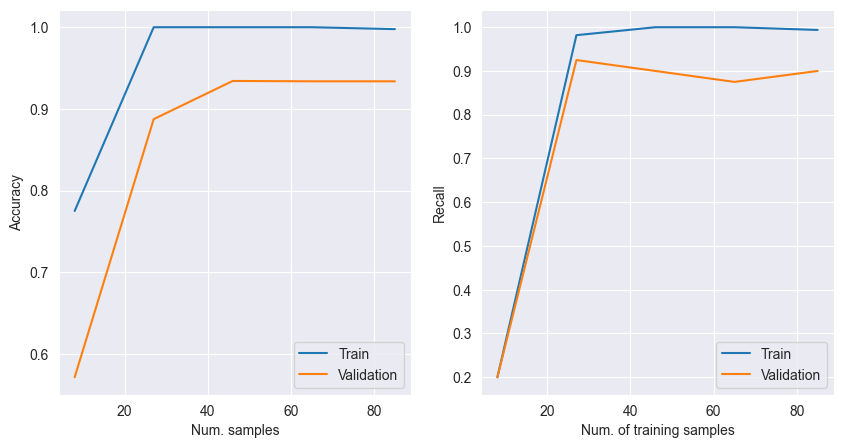

In [28]:
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(estimator=rfc, X=x_val, y=y_val, scoring='accuracy', cv=5, random_state=2)
train_sizes_abs_error, train_error, test_error = learning_curve(estimator=rfc, X=x_val, y=y_val, scoring='recall', cv=5, random_state=0)
train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []


for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

for i in range(len(train_sizes_abs_error)):
    train_avg_error.append(np.average(train_error[i]))
    test_avg_error.append(np.average(test_error[i]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy learning curve
ax[0].plot(train_sizes_abs_accuracy, train_avg_accuracy)
ax[0].plot(train_sizes_abs_accuracy, test_avg_accuracy)
ax[0].legend(['Train', 'Validation'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Num. samples')

# Error learning curve
ax[1].plot(train_sizes_abs_error, train_avg_error)
ax[1].plot(train_sizes_abs_error, test_avg_error)
ax[1].legend(['Train', 'Validation'])
ax[1].set_xlabel('Num. of training samples')
ax[1].set_ylabel('Recall')
plt.show()

Could plot against test set, but best to do again validation as it shows us how our model changes.

The learning curve changes a lot each time. This may be because there isn't much relationship between the variables and label, but we used cross validation to get rid of this issue - another reason may be because our dataset is too small. There is a fairly large gap between my train and validation sets, so I increased the train/test/validation split as I feel the graph could trend towards a more accurate union between the two sets.

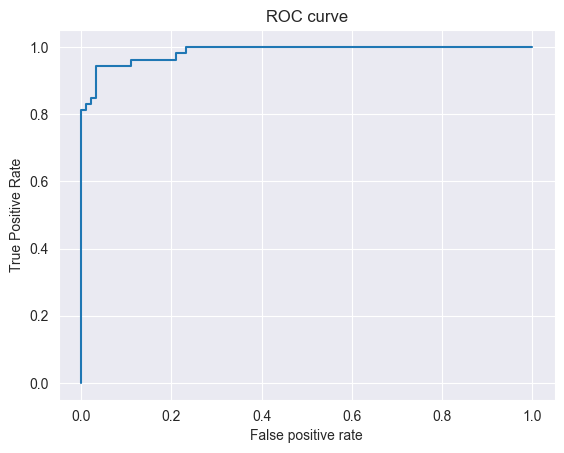

In [29]:
# After hyperparameter tuning* and feature selection*
y_real_pred = rfc.predict(x_test)
auc = roc_auc_score(y_test, y_real_pred)

y_pred_prob = rfc.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
plt.show()

In [30]:
for idx, metric in enumerate(list(zip(tpr, fpr, thresholds))[1::]):
    tpr_, fpr_, threshold =  metric[0], metric[1], metric[2]
    print(f'''
    TPR: {tpr_}
    FPR: {fpr_}
    threshold: {threshold}
    threshold_idx: {idx + 1}
    ''')


    TPR: 0.11320754716981132
    FPR: 0.0
    threshold: 1.0
    threshold_idx: 1
    

    TPR: 0.8113207547169812
    FPR: 0.0
    threshold: 0.7613919234360411
    threshold_idx: 2
    

    TPR: 0.8113207547169812
    FPR: 0.011111111111111112
    threshold: 0.7532531746031748
    threshold_idx: 3
    

    TPR: 0.8301886792452831
    FPR: 0.011111111111111112
    threshold: 0.6905674209347583
    threshold_idx: 4
    

    TPR: 0.8301886792452831
    FPR: 0.022222222222222223
    threshold: 0.6357488612836436
    threshold_idx: 5
    

    TPR: 0.8490566037735849
    FPR: 0.022222222222222223
    threshold: 0.5351380314658867
    threshold_idx: 6
    

    TPR: 0.8490566037735849
    FPR: 0.03333333333333333
    threshold: 0.5077023809523807
    threshold_idx: 7
    

    TPR: 0.9433962264150944
    FPR: 0.03333333333333333
    threshold: 0.33657537056729964
    threshold_idx: 8
    

    TPR: 0.9433962264150944
    FPR: 0.1111111111111111
    threshold: 0.19476645021645017
    t

We want to minimise false positives..

How does this graph help us? IG I could manually calculate (using the graph) the precesion, accuracy and  recall stats to determine which point is best.

In [31]:
dm = DummyClassifier()
dm.fit(x_train, y_train)
dummy_score = dm.score(x_test, y_test)
y_pred = rfc.predict(x_test)  # Model classifications
accuracy = accuracy_score(y_test, y_pred)

print(f'{"Our model beats the dummy model" if accuracy > dummy_score else "Our model does not beat the dummy model."}')

Our model beats the dummy model


In [32]:
print(classification_report(y_test, y_real_pred))
c = confusion_matrix(y_test, y_pred_real)
print(f'True negatives: {c[0][0]}')
print(f'False negatives: {c[1][0]}')
print(f'True positives: {c[1][1]}')
print(f'False positives: {c[0][1]}')

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        90
           1       0.94      0.85      0.89        53

    accuracy                           0.92       143
   macro avg       0.93      0.91      0.92       143
weighted avg       0.92      0.92      0.92       143

True negatives: 87
False negatives: 9
True positives: 44
False positives: 3
